## Process Mining - Process Model and Conformance Checking

Source: pm4py online docs (https://pm4py.fit.fraunhofer.de/)

#### Importing event logs (.XES) and identifying least and most frequent variants (along with count).

In [2]:
from pm4py.objects.log.importer.xes import factory as xes_importer
from pm4py.statistics.traces.log import case_statistics

# Importing the logs and displaying the length of the logs
event_log = xes_importer.import_log('online_ticketing_logs.xes')
print("Total event logs: ", len(event_log))

# Displaying the count of total number of variants
variants_with_count = case_statistics.get_variant_statistics(event_log)
variants_with_count = sorted(variants_with_count, key = lambda x: x['count'], reverse = True)
print("\nTotal number of variants: ", len(variants_with_count))

print("\nMost frequent variant: ", variants_with_count[0])

length = len(variants_with_count)
print("\nLeast frequent variants: \n")
for i in range(length):
    if variants_with_count[i]['count'] == 1:
        print(variants_with_count[i])

Total event logs:  4580

Total number of variants:  226

Most frequent variant:  {'variant': 'Assign seriousness,Take in charge ticket,Resolve ticket,Closed', 'count': 2366}

Least frequent variants: 

{'variant': 'Wait,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Wait,Wait,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Wait,Resolve ticket,Take in charge ticket,Wait,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Take in charge ticket,Take in charge ticket,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Take in charge ticket,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Resolve ticket,Take in charge ticket,Wait,Take in charge ticket,Wait,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Resolve ticket,Take in charge ticket,Wait,Take in charge ticket,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Resolve ticket,Resolve tick

#### Creating new event logs containing variants that have more than 1% of the traces in the log.

In [3]:
from pm4py.objects.log.exporter.xes import factory as xes_exporter
from pm4py.algo.filtering.log.variants import variants_filter

# Total number of traces: 4580
# 1% of traces: 1% of 4580 = 45.8. Hence, keeping all the variants with count above 45. In the given logs, there are total
# 9 variants with count above 45.
frequent_variants_list = []
for i in range(0, 9):
    log_variant = variants_with_count[i]['variant']
    frequent_variants_list.append(log_variant)

filtered_logs = variants_filter.apply(event_log, frequent_variants_list)

# Exporting the variants that contain more than 1% of the traces in the log to a new log file.
xes_exporter.export_log(filtered_logs, "online_ticketing_logs_1.xes")

# Displaying the total event logs in the new event log
print("Total event logs after filtering: ", len(filtered_logs))

# Displaying the total variants in the new event log
variants_with_count_fil_logs = case_statistics.get_variant_statistics(filtered_logs)
variants_with_count_fil_logs = sorted(variants_with_count_fil_logs, key = lambda x: x['count'], reverse = True)
print("\nTotal number of variants after filtering: ", len(variants_with_count_fil_logs))

Total event logs after filtering:  3811

Total number of variants after filtering:  9


#### Using Inductive Miner algorithm to discover the process model (Petri Net) on the newly created event log.

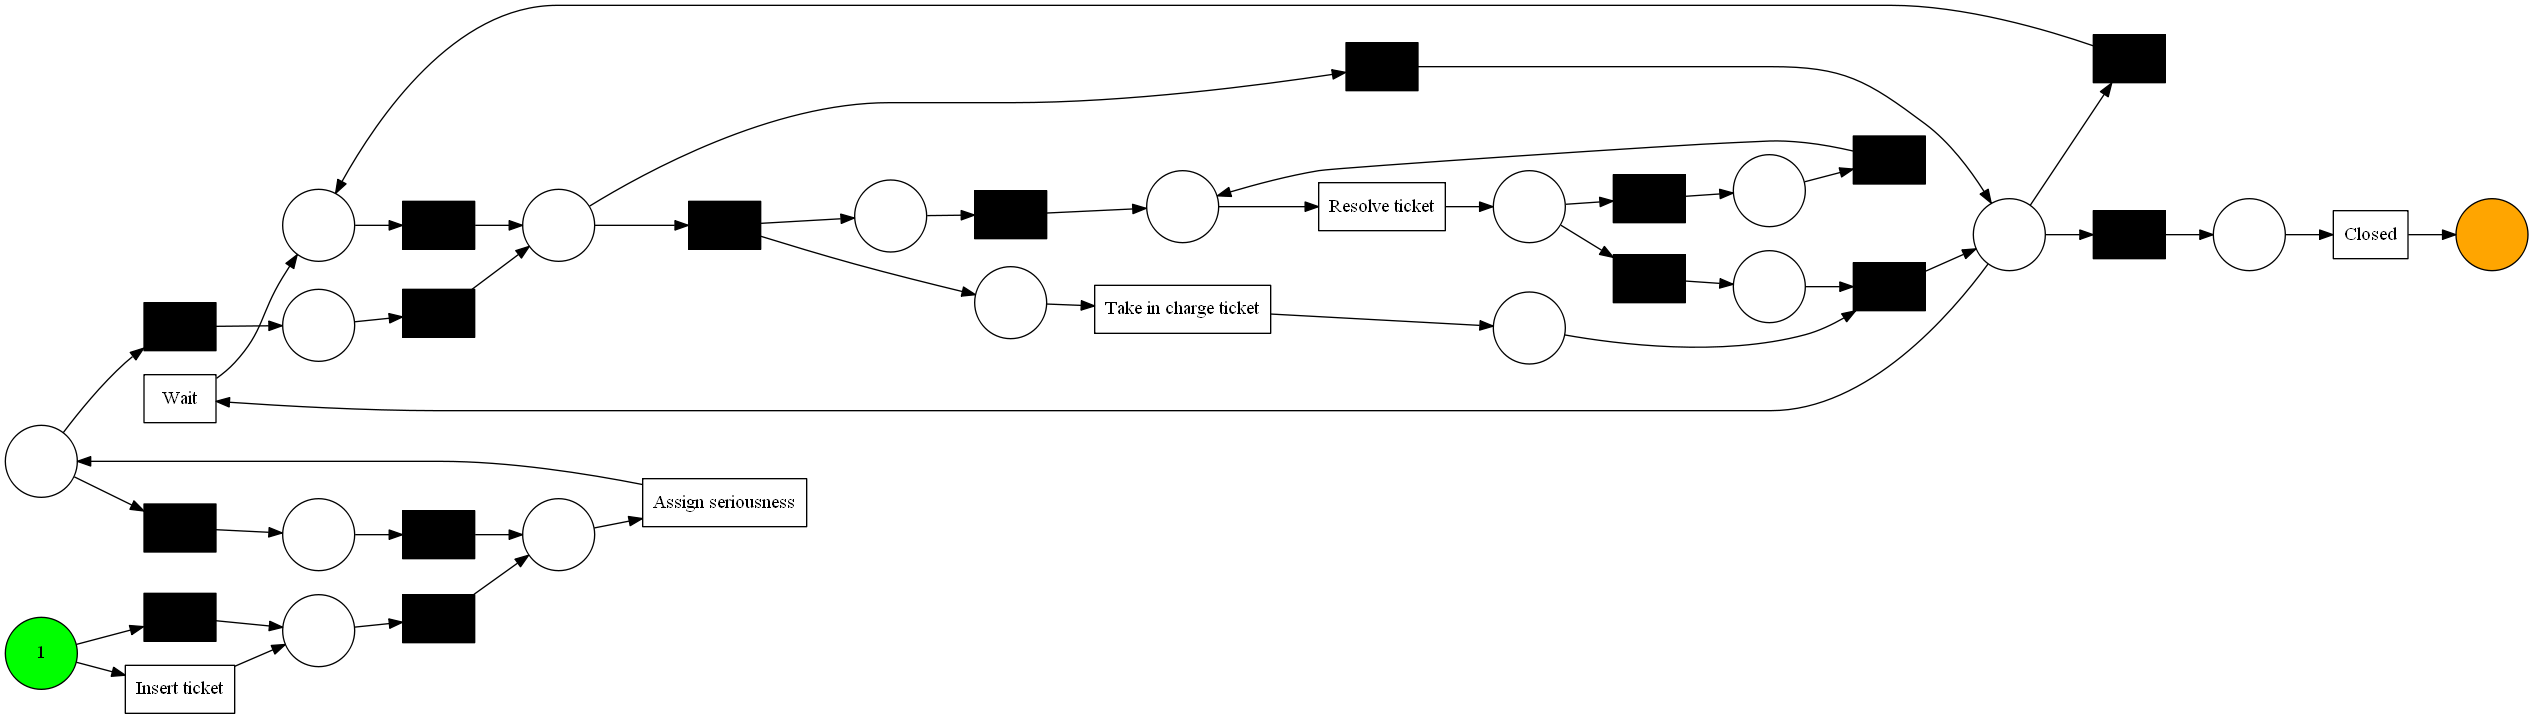

In [5]:
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.petrinet import factory as pn_vis_factory

event_log_1 = xes_importer.import_log('online_ticketing_logs_1.xes')

# Creating a process model for the log having frequent variants Inductive Miner algorithm: Petri nets
net, initial_marking, final_marking = inductive_miner.apply(event_log_1)
gviz_pn = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz_pn)

#### Using Inductive Miner algorithm to discover the process model (Process Tree) on the newly created event log.

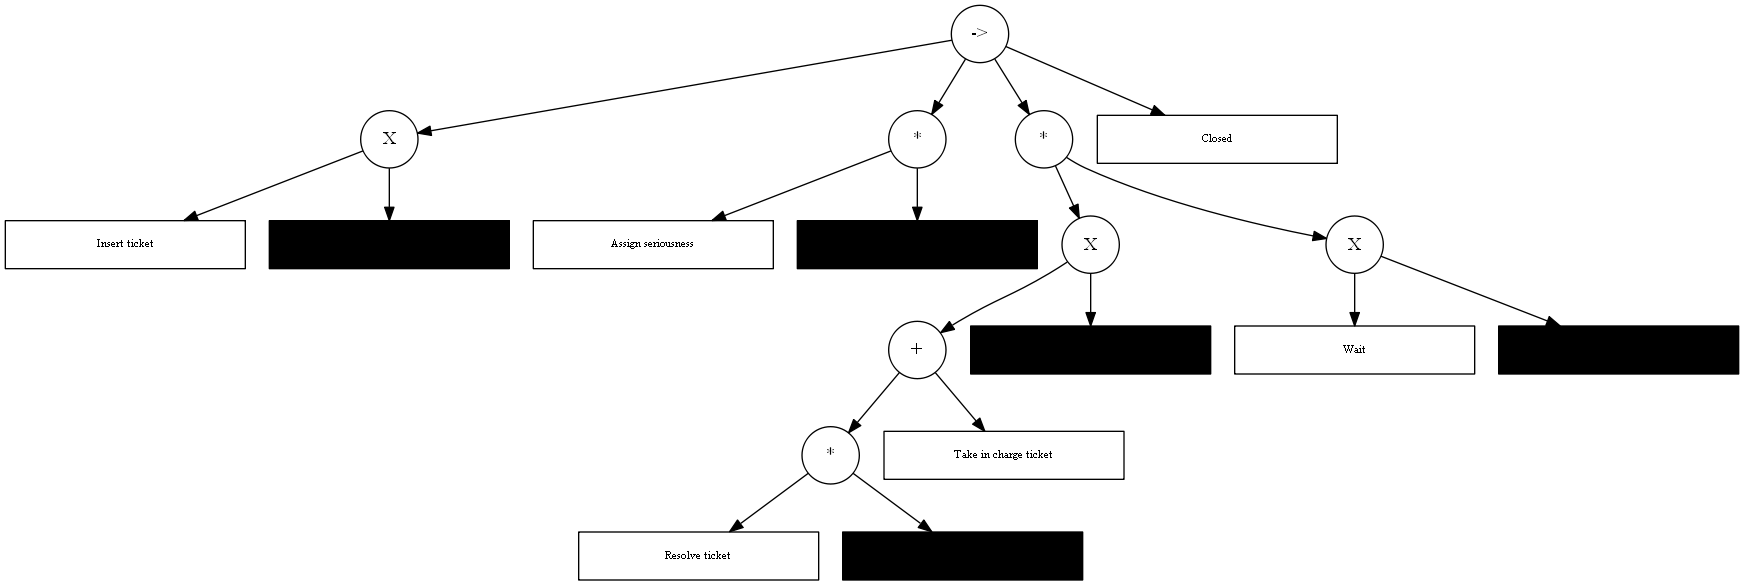

In [7]:
from pm4py.visualization.process_tree import factory as pt_vis_factory

# Creating a process model in the form of process tree
tree = inductive_miner.apply_tree(event_log_1)
gviz = pt_vis_factory.apply(tree)
pt_vis_factory.view(gviz)

#### Performing token replay conformance checking on the newly discovered process model against the original event log.

In [8]:
# Performing token replay conformance for the process model discovered
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay_factory

token_replay_conf_output = token_based_replay_factory.apply(event_log, net, initial_marking, final_marking)
print("Instance of a non-fitting trace: \n")
print(token_replay_conf_output[0]) # non-fitting trace
print("\nInstance of a fitting trace: \n")
print(token_replay_conf_output[1]) # fitting trace

Instance of a non-fitting trace: 

{'trace_is_fit': False, 'trace_fitness': 0.9375, 'activated_transitions': [skip_1, init_loop_2, Assign seriousness, skip_5, init_loop_6, tauSplit_8, Take in charge ticket, Take in charge ticket, init_loop_10, Resolve ticket, skip_13, tauJoin_9, skip_16, Closed], 'reached_marking': ['p_17:1', 'sink:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [Take in charge ticket], 'missing_tokens': 1, 'consumed_tokens': 16, 'remaining_tokens': 1, 'produced_tokens': 16}

Instance of a fitting trace: 

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [skip_1, init_loop_2, Assign seriousness, skip_5, init_loop_6, tauSplit_8, Take in charge ticket, init_loop_10, Resolve ticket, skip_13, tauJoin_9, skip_16, Closed], 'reached_marking': ['sink:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [], 'missing_tokens': 0, 'consumed_tokens': 15, 'remaining_tokens': 0, 'produced_tokens': 15}


#### Computing the overall fitness of the discovered process model.

In [9]:
# Computing log fitness
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory

fitness_tokenbasedreplay=replay_fitness_factory.apply(event_log_1, net, initial_marking, final_marking, variant="token_replay")

print("Fitness of the model discovered using the frequent variants in the event log: \n")
print(fitness_tokenbasedreplay)

Fitness of the model discovered using the frequent variants in the event log: 

{'perc_fit_traces': 73.60272894253477, 'average_trace_fitness': 0.9801796122184419, 'log_fitness': 0.9796806148777606}


#### Creating new event log by removing the two most frequent variants.

In [10]:
from pm4py.objects.log.exporter.xes import factory as xes_exporter

# Removing the two most frequent variants
less_frequent_variants_list = []
for i in range(2, 226):
    log_variant = variants_with_count[i]['variant']
    less_frequent_variants_list.append(log_variant)

less_frequent_filtered_logs = variants_filter.apply(event_log, less_frequent_variants_list)

# Exporting the variants after removing the two most frequent variants to a new log file.
xes_exporter.export_log(less_frequent_filtered_logs, "online_ticketing_logs_2.xes")

# Displaying the total event logs in the new event log
print("Total event logs after filtering: ", len(less_frequent_filtered_logs))

# Displaying the total variants in the new event log
variants_with_count_fil_logs = case_statistics.get_variant_statistics(less_frequent_filtered_logs)
variants_with_count_fil_logs = sorted(variants_with_count_fil_logs, key = lambda x: x['count'], reverse = True)
print("\nTotal number of variants after filtering: ", len(variants_with_count_fil_logs))
print("\nMost frequent variant after filtering: ", variants_with_count_fil_logs[0])

Total event logs after filtering:  1662

Total number of variants after filtering:  224

Most frequent variant after filtering:  {'variant': 'Assign seriousness,Take in charge ticket,Wait,Take in charge ticket,Resolve ticket,Closed', 'count': 228}


#### Using Inductive Miner algorithm to discover the process model (Petri Net) on the newly created event log after removing two most frequent variants.

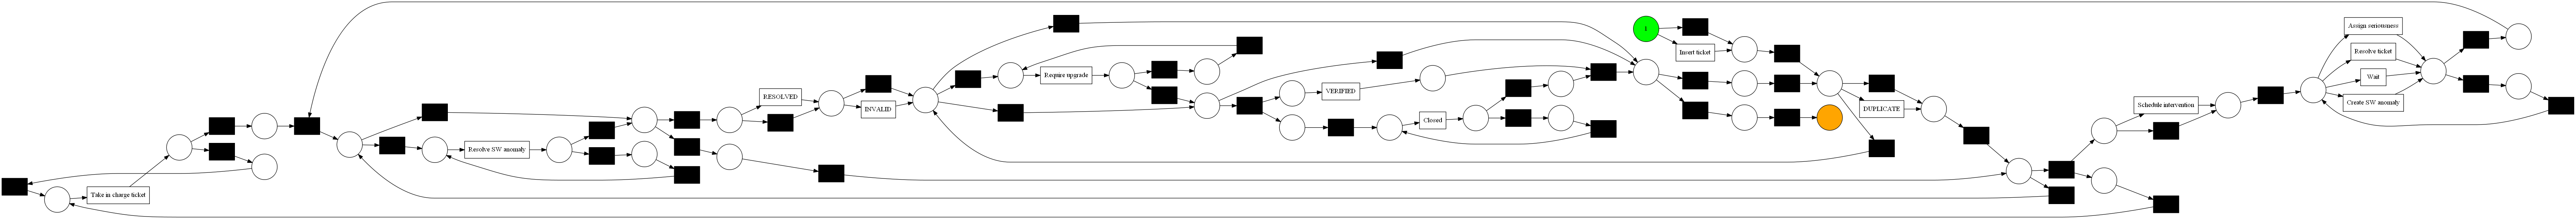

In [14]:
event_log_2 = xes_importer.import_log('online_ticketing_logs_2.xes')

# Creating a process model for the log after removing two most frequent variants using Inductive Miner algorithm: Petri nets
net2, initial_marking2, final_marking2 = inductive_miner.apply(event_log_2)
gviz_pn = pn_vis_factory.apply(net2, initial_marking2, final_marking2)
pn_vis_factory.view(gviz_pn)

#### Using Inductive Miner algorithm to discover the process model (Process Tree) on the newly created event log after removing two most frequent variants.

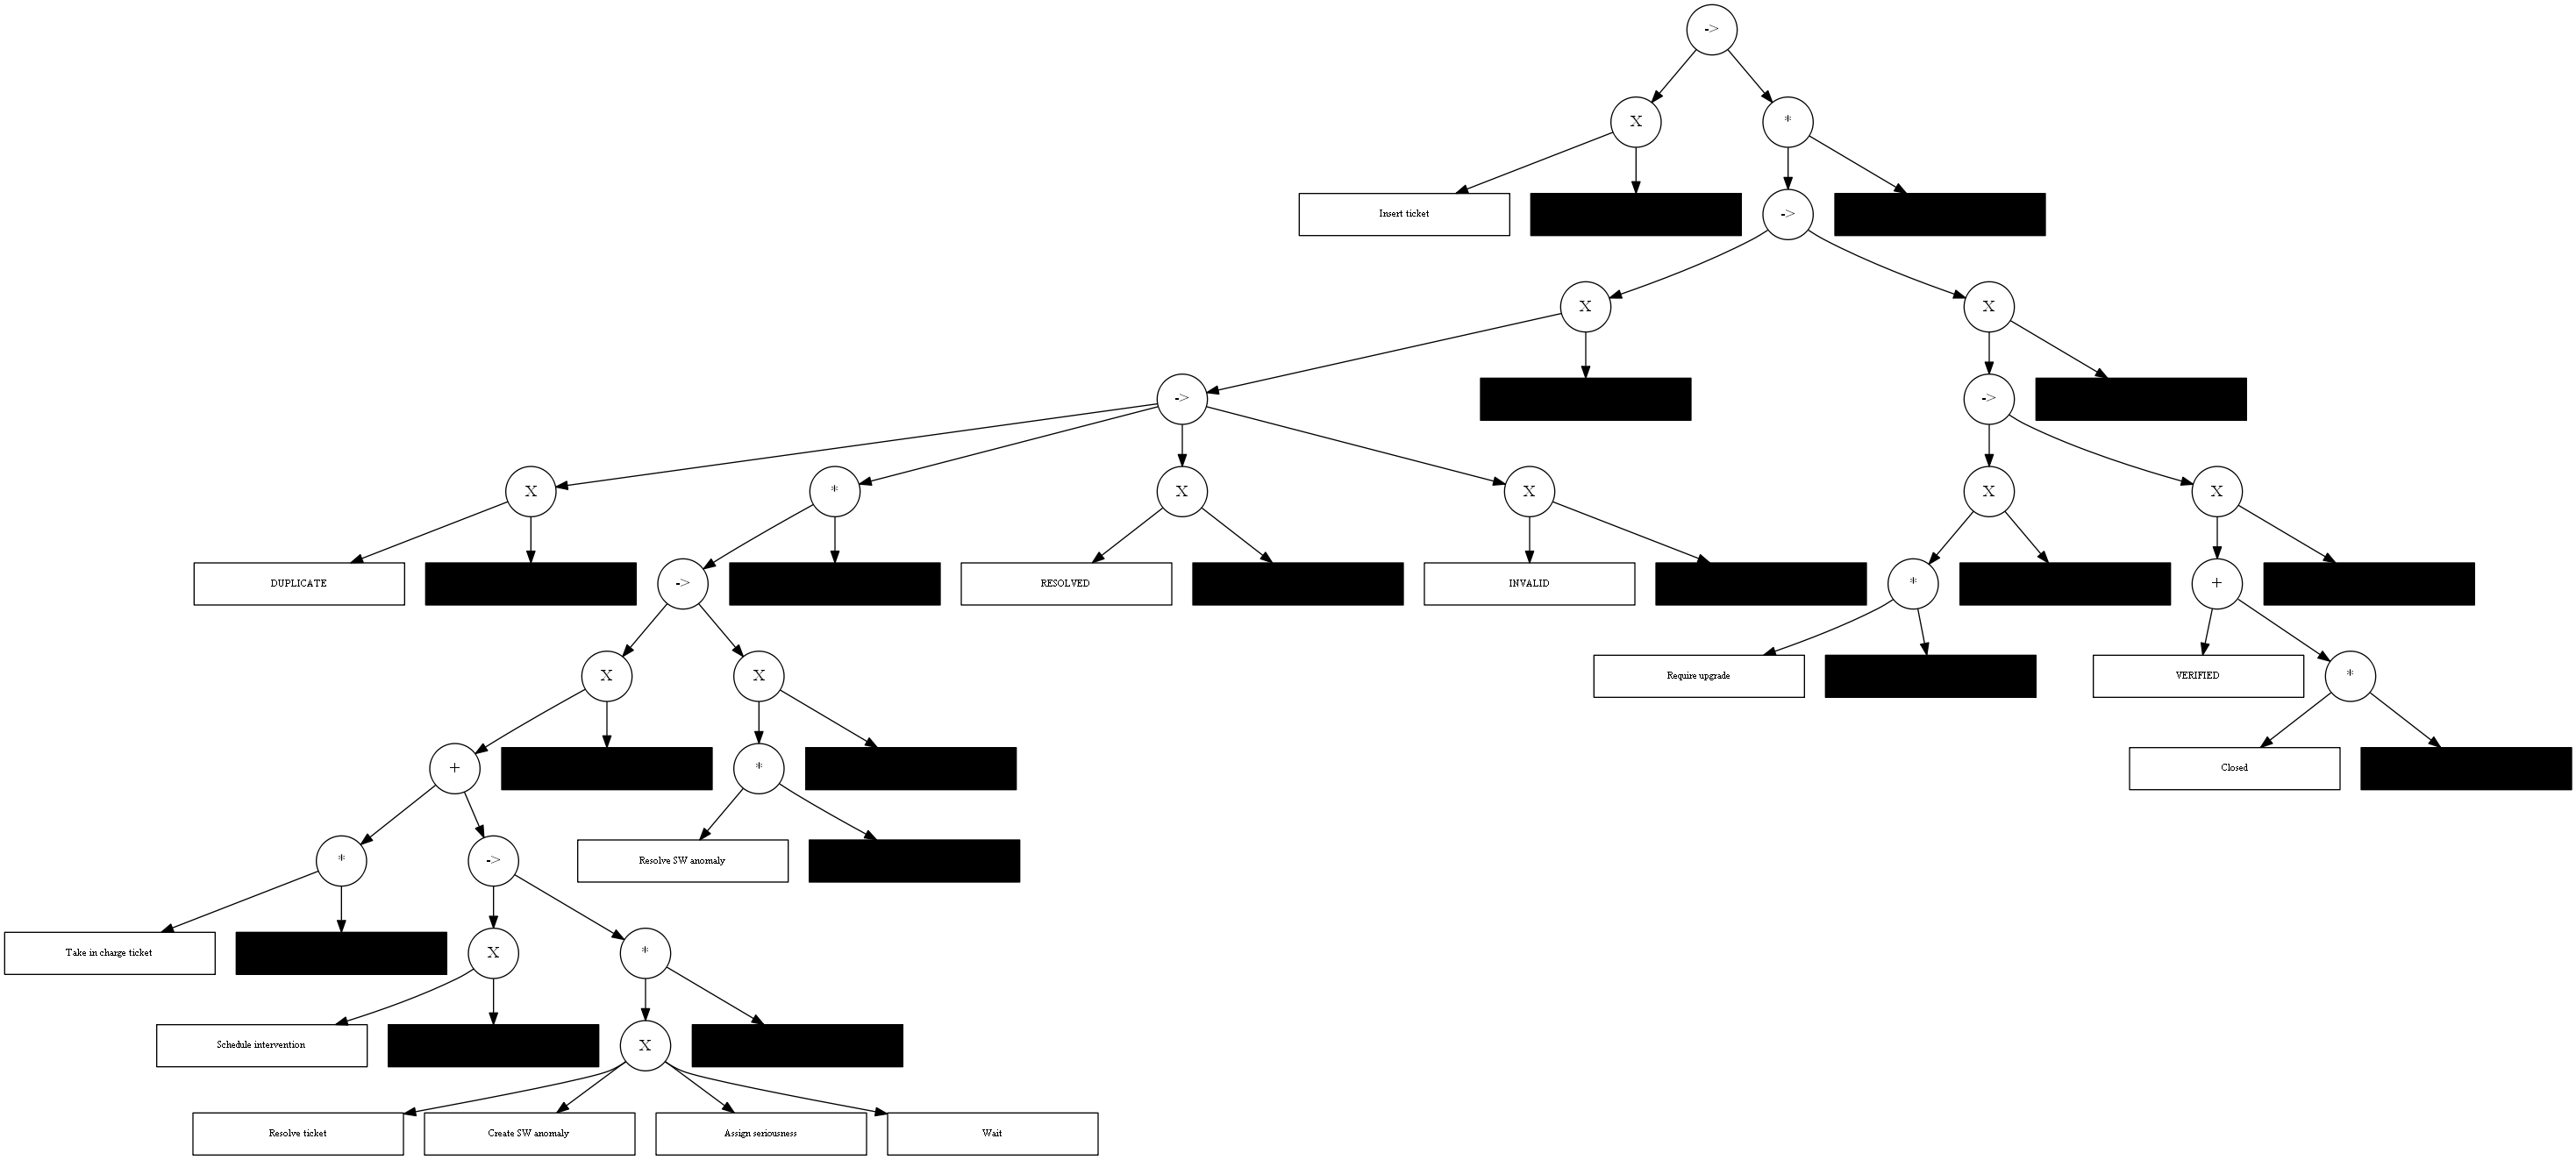

In [15]:
from pm4py.visualization.process_tree import factory as pt_vis_factory

# Creating a process model in the form of process tree
tree = inductive_miner.apply_tree(event_log_2)
gviz = pt_vis_factory.apply(tree)
pt_vis_factory.view(gviz)

#### Performing token replay conformance checking on the newly discovered process model (removing 2 most frequent variants) against the original event log.

In [16]:
# Performing token replay conformance for the process model discovered
token_replay_conf_output2 = token_based_replay_factory.apply(event_log, net2, initial_marking2, final_marking2)
print("Instance of a non-fitting trace: \n")
print(token_replay_conf_output2[2]) # non-fitting trace
print("\nInstance of a fitting trace: \n")
print(token_replay_conf_output2[0]) # fitting trace

Instance of a non-fitting trace: 

{'trace_is_fit': False, 'trace_fitness': 0.9419913419913419, 'activated_transitions': [skip_2, init_loop_3, skip_5, init_loop_6, tauSplit_8, skip_14, init_loop_15, Assign seriousness, init_loop_10, Take in charge ticket, skip_13, skip_18, tauJoin_9, skip_24, skip_26, skip_27, skip_28, init_loop_30, Require upgrade, skip_33, skip_41, skip_43, loop_4, skip_5, init_loop_6, tauSplit_8, skip_14, init_loop_15, Resolve ticket, skip_18, Closed, skip_40], 'reached_marking': ['p_13:1', 'p_19:1', 'p_36:1'], 'enabled_transitions_in_marking': {Take in charge ticket}, 'transitions_with_problems': [Closed], 'missing_tokens': 1, 'consumed_tokens': 33, 'remaining_tokens': 3, 'produced_tokens': 35}

Instance of a fitting trace: 

{'trace_is_fit': True, 'trace_fitness': 0.967741935483871, 'activated_transitions': [skip_2, init_loop_3, skip_5, init_loop_6, tauSplit_8, skip_14, init_loop_15, Assign seriousness, init_loop_10, Take in charge ticket, skip_12, loop_11, Take i

#### Computing the overall fitness of the discovered process model (removing 2 most frequent variants).

In [17]:
# Computing log fitness
fitness_tokenbasedreplay2 = replay_fitness_factory.apply(event_log_2, net2, initial_marking2, final_marking2, 
                                                         variant="token_replay")
print("Fitness of the model discovered after removing two most frequent variants in the event log: \n")
print(fitness_tokenbasedreplay2)

Fitness of the model discovered after removing two most frequent variants in the event log: 

{'perc_fit_traces': 0.601684717208183, 'average_trace_fitness': 0.9529177205424914, 'log_fitness': 0.9600344463265248}


#### Using Inductive Miner algorithm to discover the process model (Petri Net) on the original event log.

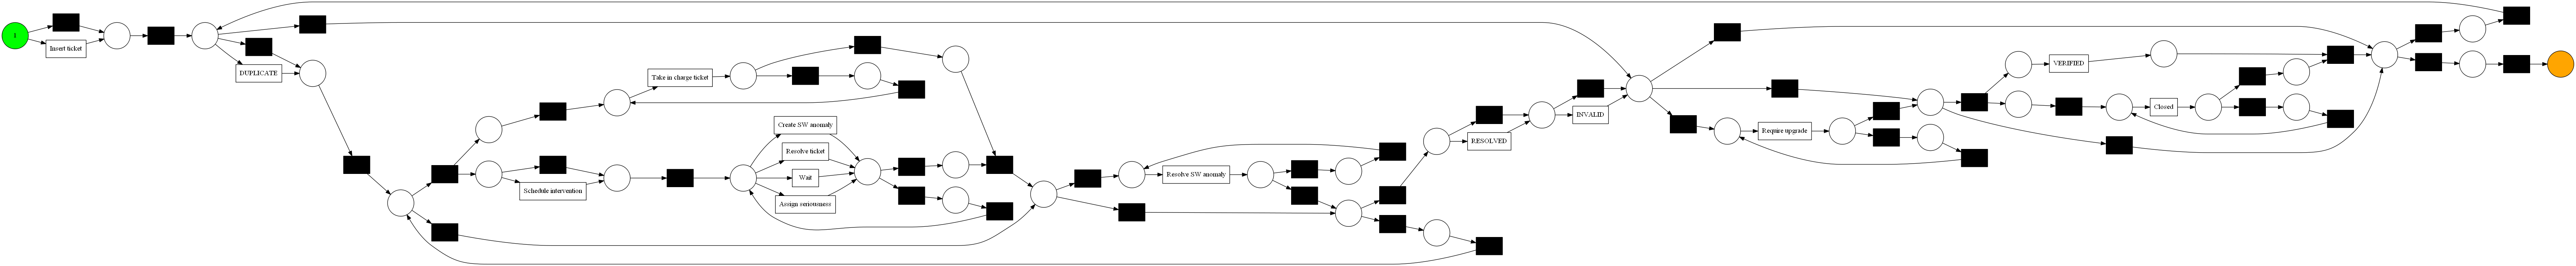

In [19]:
# Creating a process model for the original event log using Inductive Miner algorithm: Petri nets

net3, initial_marking3, final_marking3 = inductive_miner.apply(event_log)
gviz_pn = pn_vis_factory.apply(net3, initial_marking3, final_marking3)
pn_vis_factory.view(gviz_pn)

#### Using Inductive Miner algorithm to discover the process model (Process Tree) on the original event log.

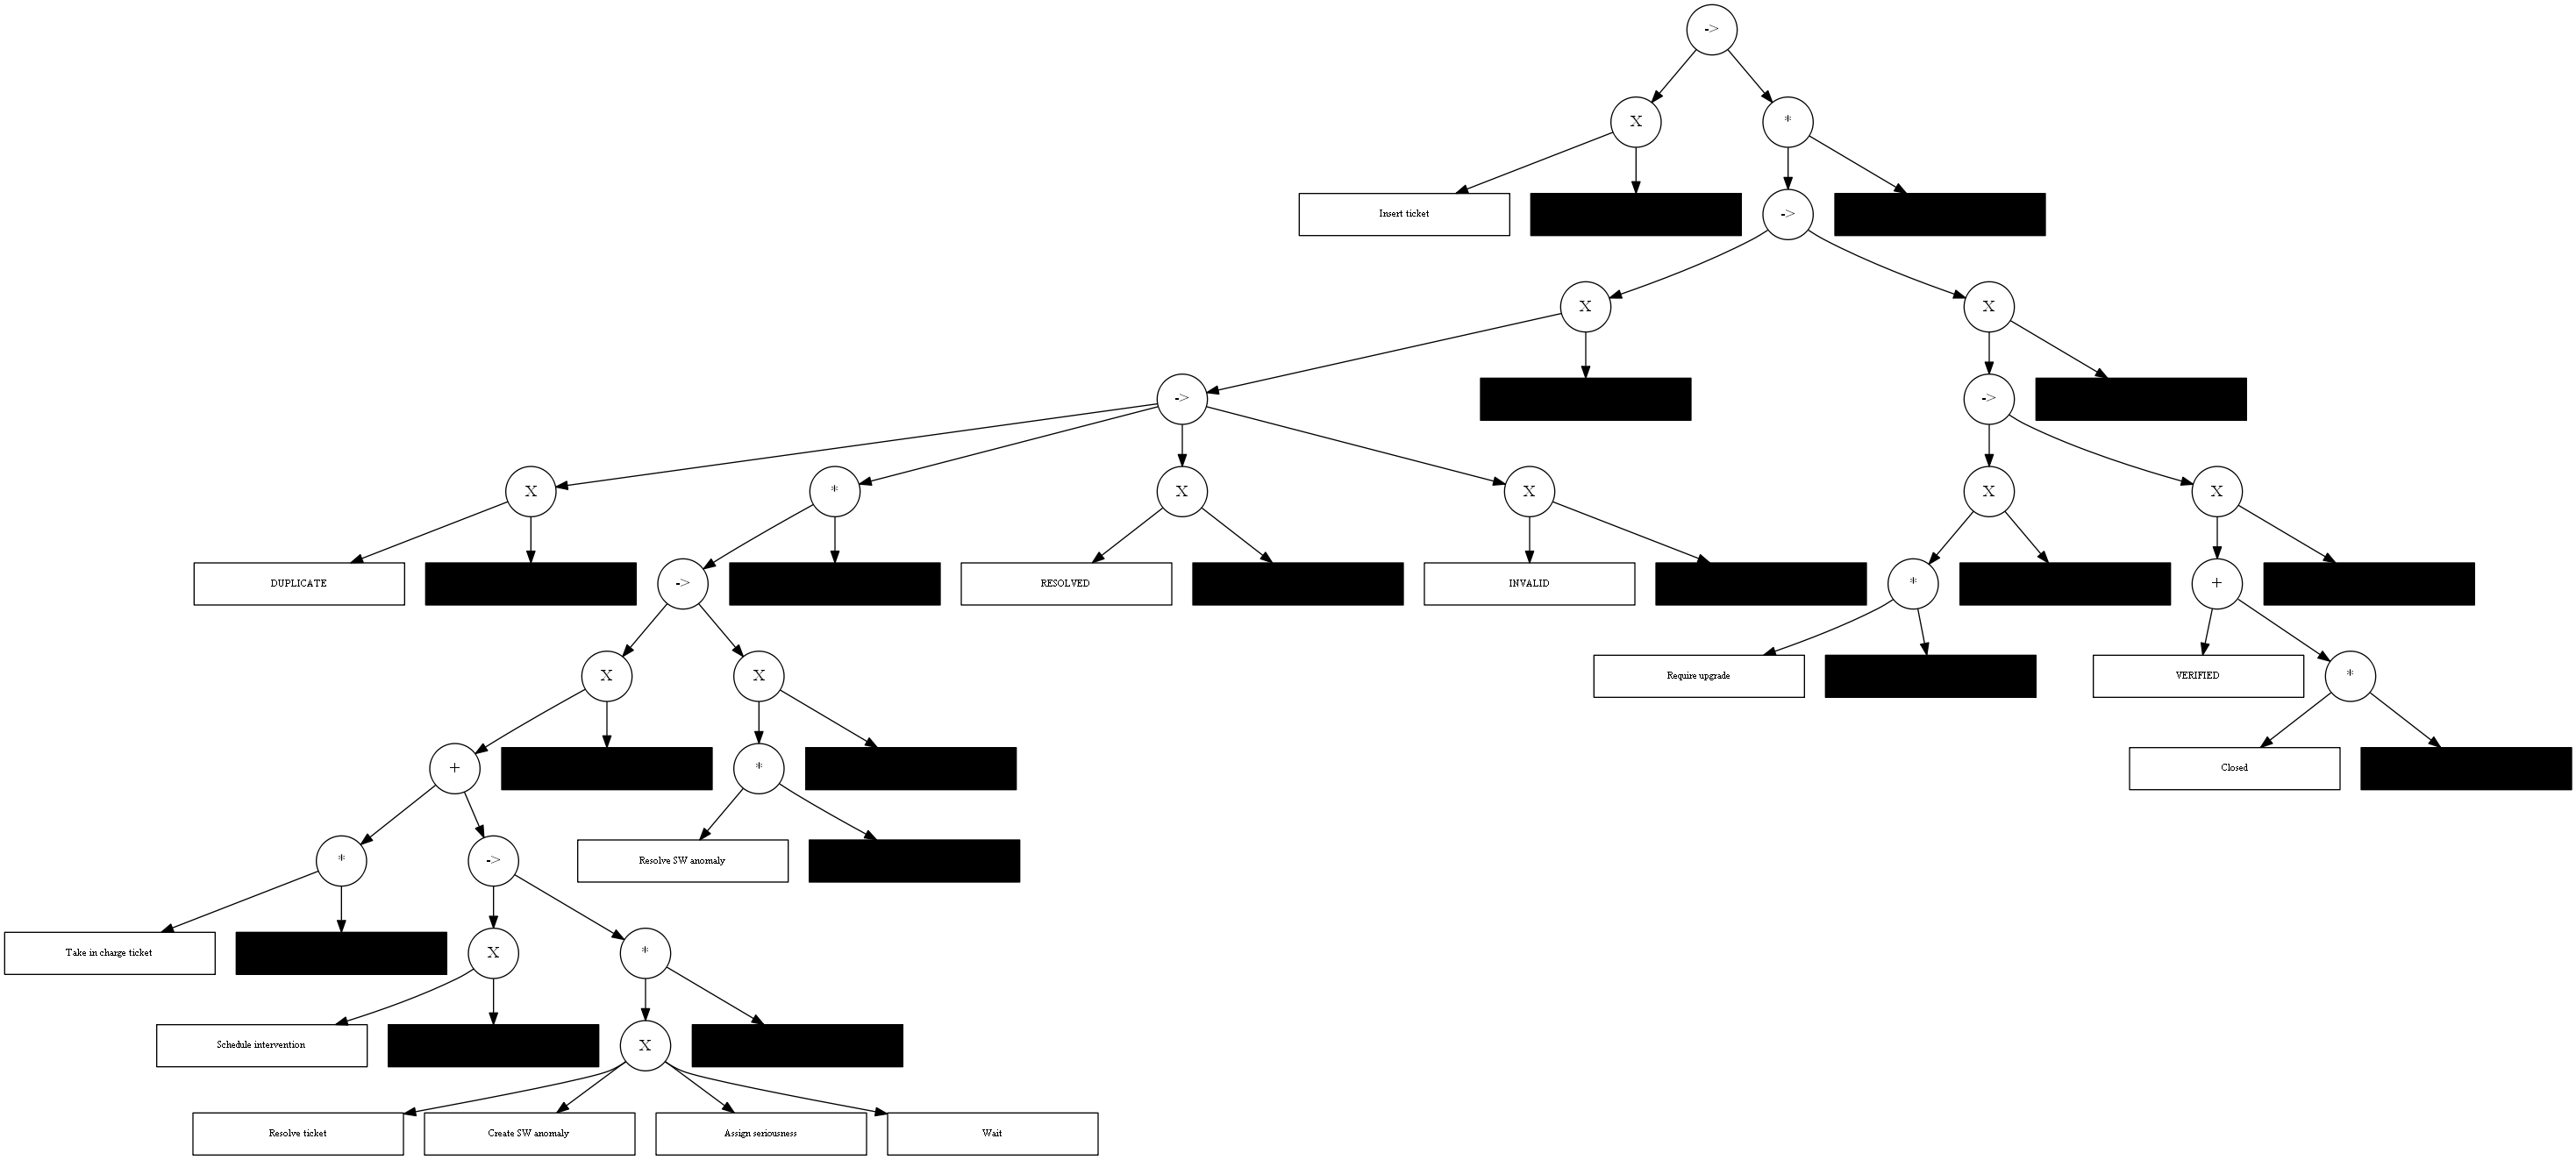

In [20]:
from pm4py.visualization.process_tree import factory as pt_vis_factory

# Creating a process model in the form of process tree
tree = inductive_miner.apply_tree(event_log)
gviz = pt_vis_factory.apply(tree)
pt_vis_factory.view(gviz)

#### Performing token replay conformance checking on the original event log and compute the fitness.

In [21]:
# Performing token replay conformance for the process model discovered
token_replay_conf_output3 = token_based_replay_factory.apply(event_log, net3, initial_marking3, final_marking3)
print("Instance of a non-fitting trace: \n")
print(token_replay_conf_output3[2]) # non-fitting trace
print("\nInstance of a fitting trace: \n")
print(token_replay_conf_output3[0]) # fitting trace

# Computing log fitness
fitness_tokenbasedreplay3 = replay_fitness_factory.apply(event_log, net3, initial_marking3, final_marking3, 
                                                         variant="token_replay")
print("\n\nFitness of the model discovered using the original event log: \n")
print(fitness_tokenbasedreplay3)

Instance of a non-fitting trace: 

{'trace_is_fit': False, 'trace_fitness': 0.9419913419913419, 'activated_transitions': [skip_2, init_loop_3, skip_5, init_loop_6, tauSplit_8, skip_14, init_loop_15, Assign seriousness, init_loop_10, Take in charge ticket, skip_13, skip_18, tauJoin_9, skip_24, skip_26, skip_27, skip_28, init_loop_30, Require upgrade, skip_33, skip_41, skip_43, loop_4, skip_5, init_loop_6, tauSplit_8, skip_14, init_loop_15, Resolve ticket, skip_18, Closed, skip_40], 'reached_marking': ['p_13:1', 'p_19:1', 'p_36:1'], 'enabled_transitions_in_marking': {Take in charge ticket}, 'transitions_with_problems': [Closed], 'missing_tokens': 1, 'consumed_tokens': 33, 'remaining_tokens': 3, 'produced_tokens': 35}

Instance of a fitting trace: 

{'trace_is_fit': True, 'trace_fitness': 0.967741935483871, 'activated_transitions': [skip_2, init_loop_3, skip_5, init_loop_6, tauSplit_8, skip_14, init_loop_15, Assign seriousness, init_loop_10, Take in charge ticket, skip_12, loop_11, Take i

#### Comparison of the 3 models:

<span style="color:black">The three process models differ from each other in terms of complexity, the more the variants, more is the number of branches in the petri nets (process model). The first model which is the simplest model does not contain all the states or activities from the event log, it depicts only the most frequent activities, whereas the second and the third process model contains all the activities or states and thus, are complex.</span><br /><br />

<span style="color:black">The first model which contain the most frequent variants is the best fitting model to the original event log because it has the best average fitness score of 0.979 which is closer to 1 that implies that it perfectly fits the event log and only a few traces deviates from the process model.</span><br /><br />

#### Visualizing the model created using original event log with frequency information.

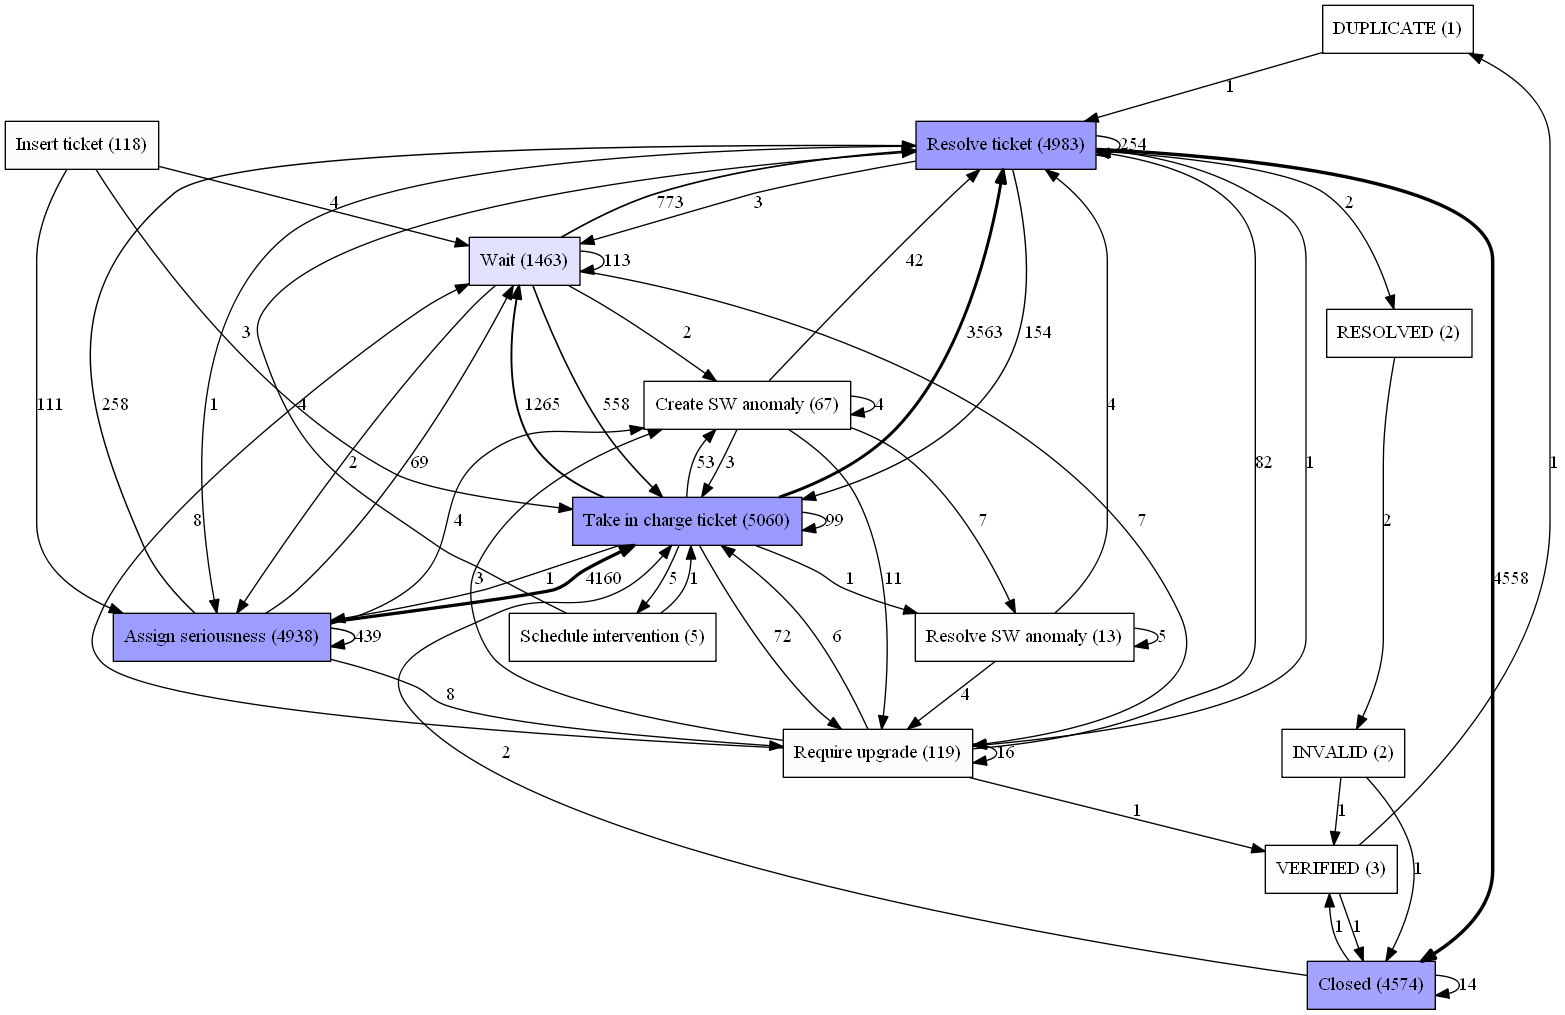

In [22]:
# Directly-follow graph visualization with frequency information
from pm4py.visualization.dfg import factory as dfg_vis_factory
from pm4py.algo.discovery.dfg import factory as dfg_factory

dfg = dfg_factory.apply(event_log)
gviz_dfg = dfg_vis_factory.apply(dfg, log = event_log, variant = 'frequency')
dfg_vis_factory.view(gviz_dfg)

#### Visualizing the model created using original event log with performance information.

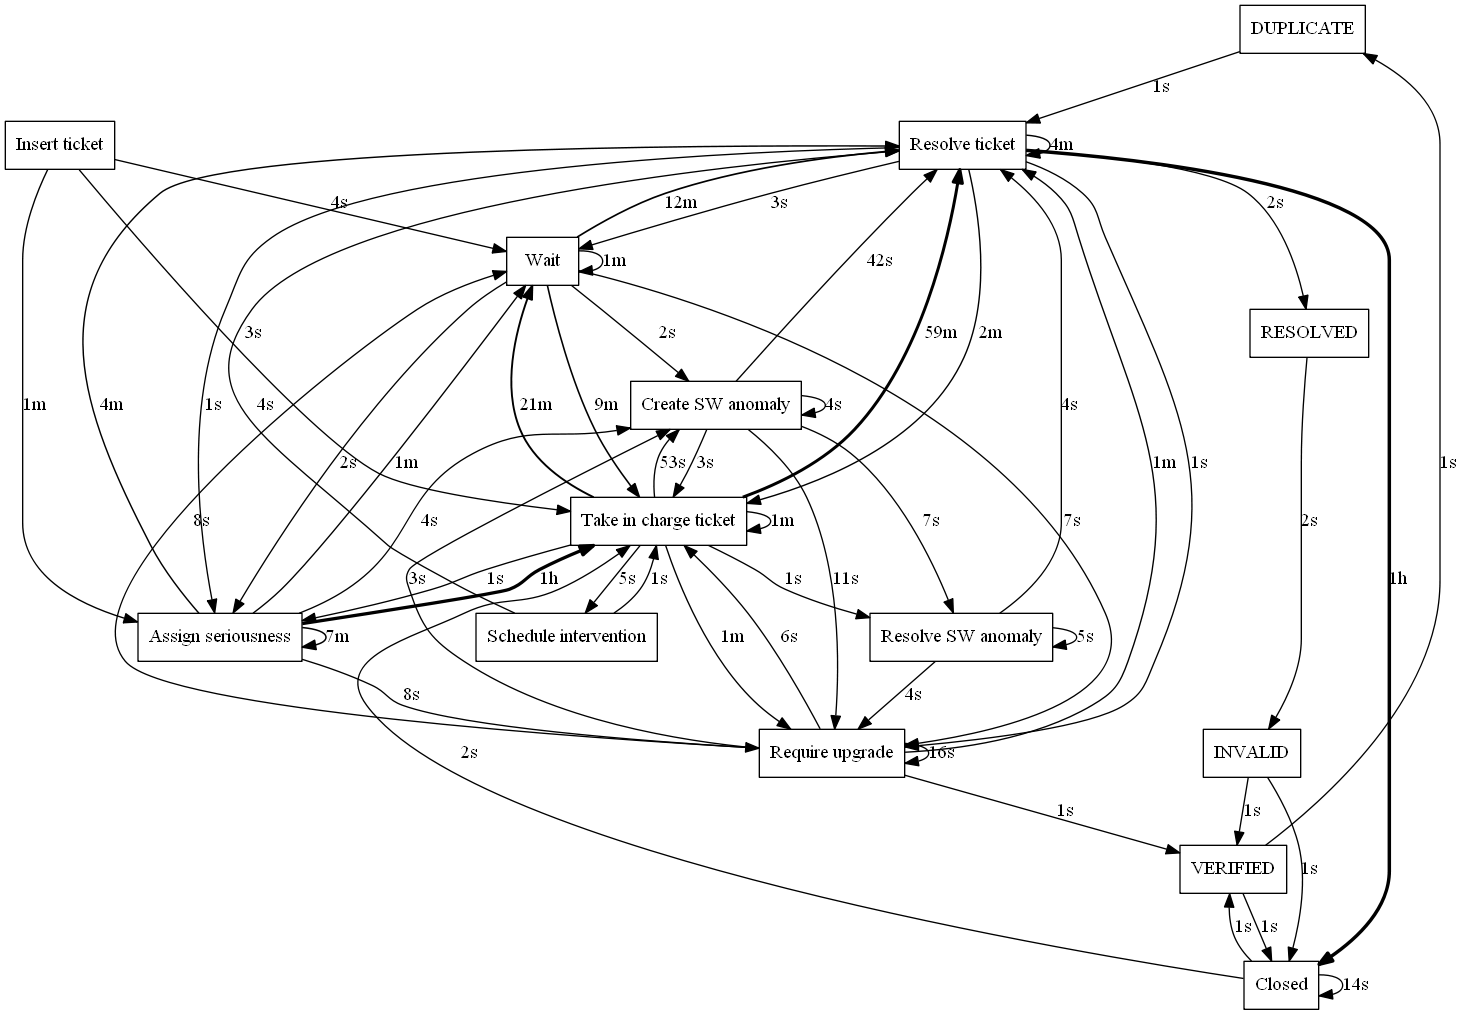

In [23]:
# Directly-follow graph visualization with performance information

gviz_dfg = dfg_vis_factory.apply(dfg, log = event_log, variant = 'performance')
dfg_vis_factory.view(gviz_dfg)

#### Final Observations:

From the above visualizations, it can be seen that the business should focus more on the parts of the process which has the highest frequency and the parts where the time taken is more to execute those processes. In the above visualization with frequency and performance information, it can be seen that the following processes are of importance:


1. Assign seriousness --> Take in charge ticket : 4160 traces and time taken is 1 hour
2. Take in charge ticket --> Resolve ticket : 3563 traces and time taken is 59 minutes
3. Resolve ticket --> Closed : 4558 traces and time taken is 1 hour


Efficiency can be maximized if more resources are allocated to the above processes.

The time taken for the activity transitions that have the most number of traces is more than the other less frequent transitions. Most of the less frequent transitions are done in few seconds or sometimes few minutes.

One of the major problem in this process is the performance bottleneck which is justified by the happy path as it takes the most amount of time given the fact that it carries the most number of traces. Also, there are many unnecessary parts in the entire process for which the time taken is few seconds, for example, 'DUPLICATE', 'VERIFIED', 'INVALID' and 'RESOLVED'. A possible rework that can be performed is removal of these parts from the process in order to make the process model less complex. Also, allocation of sufficient amount of resources for time taking activities can boost up the efficiency of the process flow.